# **Trabajo Práctico N°1** Organización de Datos 75.06 2do cuatrimestre
## GRUPO 6 - Integrantes: Sofía Javes, Gastón Frenkel, Tomás Emanuel, Valentina Adelsflügel, Víctor Zacarías



El objetivo principal del trabajo será aplicar técnicas de análisis exploratorio, preprocesamiento
de datos, agrupamiento, clasificación y regresión sobre el set de datos provisto por la empresa Properati correspondiente a
anuncios de propiedades en venta de la República Argentina publicados durante el año 2021.

# Análisis Exploratorio

### Descripción y clasificación de las variables
Para clasificar cada variable se utilizan los siguientes tipos:
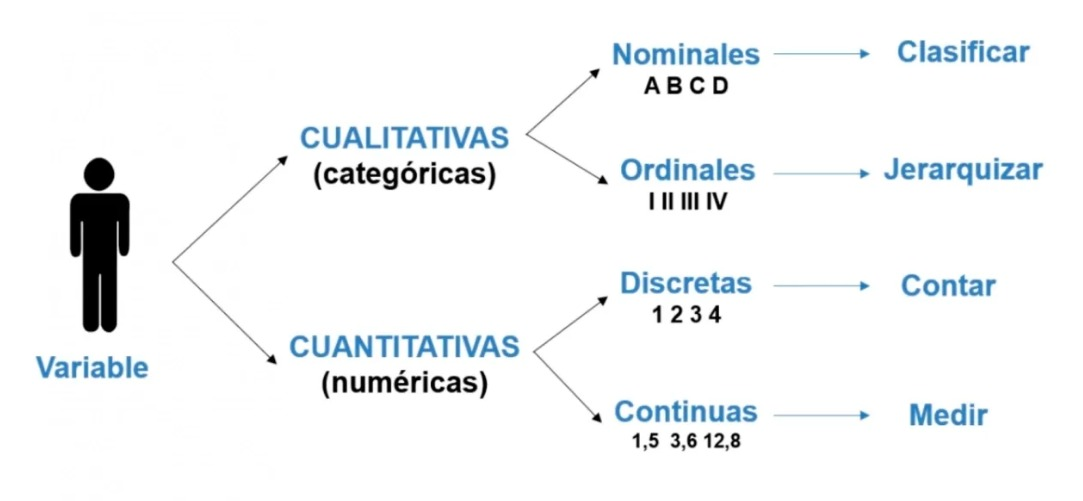
- id: Identificador del aviso. No es único: si el aviso es actualizado por la inmobiliaria (nueva versión del aviso) se crea un nuevo registro con la misma id pero distintas fechas: de alta y de baja. **(Cualitativa nominal)**
- start_date: Fecha de alta del aviso. **(Cualitativa ordinal)**
- end_date: Fecha de baja del aviso. **(Cualitativa ordinal)**
- created_on: Fecha de alta de la primera versión del aviso. **(Cualitativa ordinal)**
- place: Campos referidos a la ubicación de la propiedad o del desarrollo.**(Cualitativa nominal)**
- lat: Latitud. **(Cuantitativa continua)**
- lon: Longitud. **(Cuantitativa continua)**
- l1: Nivel administrativo 1: país. **(Cualitativa nominal)**
- l2: Nivel administrativo 2: usualmente provincia. **(Cualitiva nominal)**
- l3: Nivel administrativo 3: usualmente ciudad. **(Cualitativa nominal)**
- l4: Nivel administrativo 4: usualmente barrio. **(Cualitativa nominal)**
- property: Campos relativos a la propiedad (vacío si el aviso es de un desarrollo/proyecto). **(Cualitativa nominal)**
- operation: Tipo de operación (Venta, Alquiler). **(Cualitativa nominal)**
- type: Tipo de propiedad (Casa, Departamento, PH....). **(Cualitativa nominal)**
- rooms: Cantidad de ambientes (útil en Argentina). **(Cualitativa ordinal)**
- bedrooms: Cantidad de dormitorios (útil en el resto de los países). **(Cualitativa ordinal)**
- surface_total: Superficie total en m². **(Cuantitativa continua)**
- surface_covered: Superficie cubierta en m². **(Cuantitativa continua)**
- price: Precio publicado en el anuncio. **(Cuantitativa continua)**
- currency: Moneda del precio publicado. **(Cualitativa nominal)**
- title: Título del anuncio. **(Cualitativa nominal)**

Importación de bibliotecas a utilizar.

En caso de no tener instaladas las bibliotecas ejecutar:

In [ ]:
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install matplotlib

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None


Se carga el dataset en un dataframe de Pandas y se realiza una copia para no trabajar sobre el original.

In [ ]:
ds_properati_original = pd.read_csv('properati_argentina_2021.csv')    

In [ ]:
ds_properati = ds_properati_original.copy()    
ds_properati.head()

Procedemos a cambiar los nombres de las columnas *place_l2*, *place_l3* y *place_l4* de modo que sean más descriptivas.

In [ ]:
ds_properati.rename(columns = {'place_l2':'provincia', 'place_l3':'ciudad', 'place_l4':'barrio'}, inplace = True)
ds_properati.head(4)

Se realiza un análisis introductorio incluyendo el tamaño del dataset y los tipos de dato de cada columna.


In [ ]:
ds_properati.shape

In [ ]:
ds_properati.dtypes

Seleccionamos los datos que se van a utilizar:
únicamente los anuncios de propiedades de tipo vivienda ( Casa, PH y Departamento ) ubicados
en Capital Federal cuyo tipo de operación sea venta y su precio se encuentre en dólares (USD). Por lo tanto, analizamos qué datos tenemos en cada una de esas variables.

In [ ]:
ds_properati.operation.unique().tolist()

Vemos que las operaciones no son sólo Venta, por lo que eliminamos las filas que contengan Alquiler y Alquiler temporal ya que no nos interesan en este trabajo. 

In [ ]:
ds_properati.operation.isna().sum()

Como no hay nans eliminamos todo lo que no sea Venta directamente.

In [ ]:
ds_properati = ds_properati.drop(ds_properati.index[(ds_properati["operation"] != "Venta")])

Como se puede apreciar, ahora solo quedan entradas de propiedades en venta:

In [ ]:
ds_properati.operation.unique().tolist()

Ahora las filas que contengan datos diferentes a Casa, PH o Departamento.

In [ ]:
ds_properati.property_type.isna().sum()

Como no hay nans eliminamos todo lo que no sea Casa, Departamento, PH directamente.

In [ ]:
ds_properati = ds_properati.drop(ds_properati.index[~ds_properati.property_type.isin(["Casa","Departamento","PH"])])

Y por ultimo, eliminamos las filas que contengan un Tipo de cambio diferente a USD

In [ ]:
ds_properati.property_currency.isna().sum()

Tenemos 10476 NaNs, como serán tratados más adelante no se eliminan por el momento.

In [ ]:
ds_properati = ds_properati.drop(ds_properati.index[~ds_properati.property_currency.isin(["USD",np.nan])])

Por ultimo, eliminamos las filas de las propiedades que no sean de Capital Federal.

In [ ]:
ds_properati.provincia.isna().sum()

Como no tenemos NaNs eliminamos todo lo que no sea Capital Federal.

In [ ]:
ds_properati = ds_properati.drop(ds_properati.index[ds_properati["provincia"] != "Capital Federal"])

Podemos ver que todas las columnas elegidas quedan con los valores deseados.

In [ ]:
display(ds_properati.operation.unique().tolist())
display(ds_properati.property_type.unique().tolist())
display(ds_properati.property_currency.unique().tolist())
display(ds_properati.provincia.unique().tolist())


In [ ]:
ds_properati.shape

Vemos que redujimos el tamaño del DataSet ampliamente.

# Variables Cuantitativas
Estas pueden ser:
- Cuantitativas discretas: Estas variables toman valores numéricos siendo que entre dos valores consecutivos de las mismas no existen valores intermedios. Pueden tomar un conjunto a lo sumo numerable de valores, vinculándose generalmente al proceso de contar. 
- Cuantitativas continuas: Estas variables también toman valores numéricos, pero entre dos valores de la variable existen infinitos valores intermedios, asociándose generalmente al proceso de medir. 

En el caso de nuestro data set las variables cuantitativas, como ya se indicó mas arriba, son:
latitud, longitud, property_surface_total, property_surface_covered, price. Para trabajar sólo sobre estas se crea un nuevo data frame y se calculan medidas de resumen: media, mediana, q1, q3, moda.

In [ ]:
df_cuantitativas = ds_properati[["latitud", "longitud", "property_surface_total", "property_surface_covered", "property_price"]]
dic_cuanti = []
for i in df_cuantitativas.columns:
  dic_cuanti.append({'variable': i, 'media': df_cuantitativas[i].mean(), 
                                    'moda': df_cuantitativas[i].mode().to_list(),
                                    'mediana': df_cuantitativas[i].median(),
                                    'rango': df_cuantitativas[i].max() - df_cuantitativas[i].min(),
                                    'primer cuartil': df_cuantitativas[i].quantile(0.25),
                                    'tercer cuartil': df_cuantitativas[i].quantile(0.75)})

pd.DataFrame(dic_cuanti)

A continuación se muestran gráficos de las distribuciones de estas variables cuantitativas. Los resultados observados pueden estar afectados por los valores faltantes que más adelante se tratarán.

In [ ]:
plt.title('Distribución de la variable latitud')
plt.hist(ds_properati['latitud'], bins = 25 , alpha = 0.5) 
plt.xlabel("latitud (grados)") 
plt.ylabel("frecuencia")
plt.grid(True)
plt.show()

In [ ]:
plt.title('Distribución de la variable longitud')
plt.hist(ds_properati['longitud'], bins = 25 , alpha = 0.5) 
plt.xlabel("longitud (grados)") 
plt.ylabel("frecuencia")
plt.grid(True)
plt.show()

In [ ]:
plt.title('Distribución de la variable property_surface_total')
plt.hist(ds_properati['property_surface_total'], bins = 25 , alpha = 0.5) 
plt.xlabel("property_surface_total (m²)")
plt.ylabel("frecuencia")
plt.grid(True)
plt.show()

In [ ]:
plt.title('Distribución de la variable property_surface_covered')
plt.hist(ds_properati['property_surface_covered'], bins = 25 , alpha = 0.5) 
plt.xlabel("property_surface_covered (m²)") 
plt.ylabel("frecuencia")
plt.grid(True)
plt.show()

Hasta acá notamos una distribución uniforme de estas variables.

In [ ]:
plt.title('Distribución de la variable property_price')
plt.hist(ds_properati['property_price'], bins = 25 , alpha = 0.5) 

scale_factor = 0.5
xmin, xmax = plt.xlim()
plt.xlim(xmin * scale_factor, xmax * scale_factor)

plt.xlabel("property_price (USD) . 1e7") 
plt.ylabel("frecuencia")
plt.grid(True)
plt.show()


# Variables Cualitativas
Estas pueden ser: 

- Nominales: Se diferencian de las Ordinales ya que no necesariamente llevan un orden. Dentro de esta clasificacion podrían llegar a ser de texto o numéricas:
    - Texto: Estas podrían ser, por ejemplo el color de ojos de una persona, o algo no necesariamente ordenable.
    - Numéricas: Pueden ser por ejemplo ids, o numeros de telefono.
- Ordinales: Una variable cualitativa ordinal podría ser aquella que tenga una escala establecida, con valores ordenados. 
    - Texto: Esta puede ser por ejemplo las medallas de un torneo (Oro,plata,bronce), que mantienen un orden siendo la mejor Oro y la peor la de Bronce.
    - Numéricas.

En el principio del tp ya definimos todos las variables cualitativas que encontramos.
Ahora mostramos los valores posibles de cada variable cualitativa, exeptuando las que tienen solamente un valor.


In [ ]:
df_cual_nominal = ds_properati[["property_type","ciudad","property_rooms","property_title","property_bedrooms"]]
dic_cual_nominal = []
for cual in df_cual_nominal.columns:
  dic_cual_nominal.append({"variable": cual, "tipos" : ds_properati[cual].unique().tolist()})
pd.DataFrame(dic_cual_nominal)


Calculamos la frecuencia de cada categoria segun los valores tomados.

Para cada categoria tenemos:

In [ ]:
ds_agrupado_PT = ds_properati["property_type"].value_counts()
ds_agrupado_PL_3 = ds_properati["ciudad"].value_counts()
ds_agrupado_PR = ds_properati["property_rooms"].value_counts()
ds_agrupado_CO = ds_properati["created_on"].value_counts() 
ds_agrupado_BR = ds_properati["property_bedrooms"].value_counts()


Con sus respectivas tablas con la frecuencia:

In [ ]:
display(ds_agrupado_PT)

Para property Rooms (ambientes)

In [ ]:
display(ds_agrupado_PR)

Para bedrooms:

In [ ]:
ds_agrupado_BR

Para ciudad:

In [ ]:
display(ds_agrupado_PL_3)

Por fecha de creación:

In [ ]:
display(ds_agrupado_CO)

Se puede observar que para la categoría de ciudad la zona más frecuente de venta de propiedades es en Palermo, además de esto se puede ver que el tipo de propiedad más frecuente en venta es el de Departamento. Para el caso de los ambientes, se puede ver que el más frecuente son 3 y para las habitaciones es 1. No le vemos mucho sentido mostrar todos los tipos de "property title" ya que no hay valores frecuentes. También se ve que para la categoría de bedrooms, el valor más frecuente es 1. Por último, se puede ver que se crearon publicaciones todos los días del año siendo el más frecuente el 16 de Diciembre con 17417 publicaciones.
 Se podría hacer un gráfico con los resultados más frecuentes (para mejor visualización). Si hay muchos tipos lo truncamos en los 10 valores más frecuentes para poder ver mejor.


In [ ]:
ds_agrupado_PL_3[:10].plot(kind = "barh", title="Frecuencia de valores de la variable ciudad", xlabel="frecuencia",ylabel="zona")

In [ ]:
ds_agrupado_PT.plot(kind = "barh", title="Frecuencia de valores de la variable Property Title", xlabel="frecuencia",ylabel="Tipo de Venta")

In [ ]:
ds_agrupado_PR[:10].plot(kind = "barh", title="Frecuencia de valores de la variable Property Rooms", xlabel="frecuencia",ylabel="Cantidad de ambientes")

In [ ]:
ds_agrupado_CO[:10].plot(kind = "barh", title="Frecuencia de valores de la variable created_on", xlabel="frecuencia",ylabel="Fecha de Publicacion")

In [ ]:
ds_agrupado_BR[:10].plot(kind = "barh", title="Frecuencia de valores de la variable property_bedrooms", xlabel="frecuencia",ylabel="cant de habitaciones")

**Variables irrelevantes en el analisis**

Se descartan las columnas de **id** (que no son de utilidad para el análisis ya que no aportan información alguna sobre las propiedades), **property_title** (porque solamente es una forma que tiene el vendedor de identificar su anuncio, que suele contener la información que ya figura en las otras variables). También sacamos la fecha de inicio (porque es igual a la fecha de creación) y de fin de la publicación

In [ ]:
ds_properati.drop(["id", "property_title","start_date","end_date"], axis=1, inplace=True)
ds_properati.reset_index(drop=True,inplace=True)
ds_properati.head()

## Covarianza y Correlación

Tanto la covarianza como la correlación son medidas de asociación lineal entre dos variables.
La Covarianza indica la dirección/sentido de esa asociación lineal y la Correlación mide tanto la fuerza como el sentido de dicha asociación lineal.

El valor (magnitud) de la covarianza depende las unidades en que se miden las variables.
Si las escalas de medida de las variables fueran muy diferentes, la variabilidad estaría dominada por las variables con mayores magnitudes.

La Correlación se define como la covarianza de los datos estandarizados, por lo que evita el problema de las diferencias en las escalas de medición. Se obtiene dividiendo la covarianza de dos variables por el producto de sus desvíos estándar.

Los valores del coeficiente de correlación van de -1 a 1. Cuanto más cerca esté de 1 (lineal perfecta positiva) o -1 (lineal perfecta negativa), más estrechamente relacionadas estarán las dos variables. El signo positivo significa la dirección de la correlación, es decir, si una de las variables aumenta, se supone que la otra también aumentará. Al contar con una muestra poblacional se calcula la correlación mediante un estimador muestral que es el de Pearson.



In [ ]:
matriz_cov = ds_properati.cov(numeric_only=True)
matriz_cov

In [ ]:
matriz_corr=ds_properati.corr(numeric_only=True)
matriz_corr

A continuación se muestra la matriz de correlación en un Heatmap:

In [ ]:
plt.figure(figsize = (15,8))
sns.heatmap(matriz_corr, annot = True, cmap='coolwarm')


Se orbserva una la "cruz" blanca correspondiente a los valores NaN (100%) de la columna *place_l6*.
Por otro lado, siguiendo la escala de colores aquellas celdas más cercanas al rojo presentan una buena correlación lineal positiva (lineal creciente). En este caso no se observan correlaciones cercanas a -1, que también implicarían relación linealidad pero decreciente.

Teniendo esto en cuenta, vemos que las variables que mejor se relacionan linealmente son: (Ignoramos la diagonal, dado que es la correlación de la variable consigo misma que siempre es perfecta)
- *property_bedrooms* con *property_rooms*  ($\rho$ = 0.87)
- *property_surface_total* con *property_surface_covered*  ($\rho$ = 0.65)


In [ ]:
#sns.pairplot(ds_properati, height=2)

En este pairplot podemos ver las distribuciones bivariadas. En especial nos sirve para efectivamente ver que *property_surface_total* con *property_surface_covered*  y *property_bedrooms* con *property_rooms* tienen una bastante tendencia lineal tal como exponía su correlacion de pearson. 

### Datos Faltantes

##### Columnas 

Para todas las columnas se realiza la cuenta del porcentaje de los datos faltantes

In [ ]:
porcentajes = ds_properati.isna().sum() / len(ds_properati) * 100
porcentajes

In [ ]:
ds_properati["barrio"].value_counts()

Se puede notar que las columnas con mayor datos faltantes son las de place_l6, place_l5 y barrio, siendo los primeros 2 un 100% de datos faltantes y barrio teniendo un 95% de datos faltantes, siendo Palermo Hollywood el dato no nulo mas frecuente.

Realizamos un gráfico a partir de los nans de las variables con respecto al total del dataset.

In [ ]:
porcentajes.plot(kind = "barh", title="Porcentaje de datos nulos respecto del total del dataset", xlabel="Porcentaje",ylabel="Variable")
plt.show()

##### Filas

Por otro lado, calculamos el porcentaje de datos faltantes por cada registro sobre el total de datos del registro.

In [ ]:
porcentaje_Nan_fila = (ds_properati.isnull().sum(axis=1) / ds_properati.columns.size * 100).sort_values(ascending=False).value_counts()
porcentaje_Nan_fila

Lo que se muestra arriba corresponde al porcentaje de nans a la izquierda y a la derecha la cantidad de filas que tienen ese porcentaje.

In [ ]:
(ds_properati.isnull().sum(axis=1)).sort_values(ascending=False).value_counts()

Se puede ver que hay 1 registro con 11 valores faltantes, 4 con 10 y 4 con 9 siendo estos los registros con más valores faltantes (se muestran a continuación). También se puede analizar que 71160 registros tienen 3 valores faltantes, por lo que se puede concluir que es mucho más frecuente tener 3 registros faltantes. 

In [ ]:
ds_properati[(ds_properati.isnull().sum(axis=1) == 11) | (ds_properati.isnull().sum(axis=1) == 10) | (ds_properati.isnull().sum(axis=1) == 9)]

Se pueden graficar estos porcentajes para obtener una mejor visualizacion de los datos

In [ ]:
porcentaje_Nan_fila.plot(kind = "barh", title="Porcentaje de datos nulos respecto del total del dataset", xlabel="Cantidad de registros",ylabel="Porcentaje")
plt.show()

A partir de este grafico se puede concluir que aproximadamente 71 mil registros tienen 18.8% de datos faltantes, siendo este el porcentaje mas frecuente de datos faltantes en un registro.

#### Estrategias para aplicar en los datos faltantes

##### Opción 1: Eliminar registros o variables
Para un primer enfoque, si el porcentaje de una columna frente a los datos faltantes es muy grande, se podría borrar la columna entera, ya que al tener en su mayoría valores faltantes, estos no aportan valor al dataset.

Esta estrategia es particularmente útil en aquellos casos en los que los datos faltantes sean MCAR (missing completly at random), ya que en estos casos se tiene la certeza de que no es posible recuperar los datos faltantes bajo algún criterio. En otro caso, la eliminación de una columna puede generar pórdidas de información, por lo que es una estrategia que debe usarse con precaución.

##### Opción 2: Crear otra Categoría
Por otro lado, se podría de tomar los datos faltantes de la columna como una categoría más, incluyendo una descripción breve de qué significan los datos faltantes. Por ejemplo en nuestro dataset, dentro de la columna "property rooms", al tener un 1% de datos faltantes, se podría considerar una nueva categoría "ambientes no reportados" incluyendo a estos.

##### Opción 3: Imputaciones

Otra estrategia es la de la imputación, que comprende un subconjunto de estrategias que permiten reemplazar los datos faltantes por datos con información significativa bajo algún criterio. Cual de estas estrategias usar depende de las necesidades del problema, o de los recursos de los que se disponga.

Como ya se mencionó, la opción 3 es una agrupación de un conjunto de estrategias para resolver un mismo problema, el de imputar información, se describen algunas de ellas:

**1-Sustitución de datos:** Es un simple reemplazo de valores no observados. Se basa en la consulta a expertos en los datos analizados.

**2-Sustitución por media o mediana:** Entre el conjunto de datos analizado, se toma el promedio de ellos, y se reemplazan los datos faltantes por el mismo (no conviene hacerlo cuando gran mayoría de los datos son faltantes o nulos).

**3-Imputación Cold Deck** Selecciona valores de fuentes distintas a la base de datos analizada, esto es, se busca información oficial que permita rellenar los datos faltantes.

**4-Imputacion Hot Deck:** Reemplaza valores faltantes con valores similares entre si (un ejemplo de esto, es tener que rellenar cuantos baños tiene un apartamento de 3 ambientes tomando como referencia datos de otros departamentos de 3 ambientes dentro del dataset).

**5-Imputación por regresión:** Se predice el dato faltante a través de un modelo de regresión.

**6-MICE (multivariate imputation by chained equations):** Se usa basandose de que el origen de los datos faltantes es missing at random (MAR). Este proceso de imputación es un proceso iterativo, en cada iteración cada valor faltante se produce en función de las variables restantes. Cuántas iteraciones hacer depende del problema a resolver.


Para las columnas de place_l5 y place_l6 decidimos usar la opción 1 ya que la gran mayoría de valores son datos faltantes, por lo que no tendría sentido tomar una media de sus valores. Además no sabemos qué representan porque no se provee información de estas variables en la fuente de la que proviene el set de datos.


In [ ]:
columnas_a_eliminar = ["place_l5","place_l6"]
ds_properati.drop(columnas_a_eliminar, axis='columns', inplace=True)

##### Análisis de valores faltantes en *barrio*

Analizamos qué hacer con *barrio*. En primer lugar listamos los valores de *ciudad* y *barrio* para ver qué representan.

In [ ]:
ds_properati["ciudad"].unique()

In [ ]:
ds_properati["barrio"].unique()


Aquí se puede observar que en el caso de Capital Federal *ciudad* hace referencia al barrio y que los valores de *barrio* no son relevantes frente a los otros. Por lo tanto, dada la alta cantidad de NaNs se procede a eliminar la columna.

In [ ]:
ds_properati.drop("barrio", axis=1, inplace=True)
ds_properati = ds_properati.rename(columns={'ciudad':'barrio'})
ds_properati.head(3)

Dado que contamos con las latitudes y longitudes de la ubicación de las observaciones, vamos a imputar los datos faltantes de *ciudad* usándolos si no son nulos. Para eso utilizaremos Geopandas y los polígonos de barrios de CABA provistos por la página del gobierno de la ciudad. Se estaría realizando una imputación Cold Deck.

In [ ]:
ds_properati['barrio'].isnull().sum()

Tenemos 435 filas con *ciudad* NaN.

In [ ]:
ds_properati.reset_index(drop=True, inplace=True) #acomodamos el ds

In [ ]:
!pip install geopandas
import geopandas as gp

In [ ]:
poligonos = gp.read_file("barrios.geojson")
poligonos.head()


Graficamos los polígonos.

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

ax.set_title('Barrios de CABA')

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
poligonos.plot(ax=ax,column='BARRIO')

Se descartan las coordenadas NaNs ya que no son el objetivo de esta ocasión y creamos otro data frame que contenga las filas con ciudades NaN.

In [ ]:
ds_copia = ds_properati.copy()

ds_barrio_nan = ds_copia.loc[(ds_copia["barrio"].isna()) & (ds_copia["latitud"].isna()==False) & (ds_copia["longitud"].isna()==False)]
ds_barrio_nan.head(3)

In [ ]:
display(ds_barrio_nan.barrio.unique())
display(ds_barrio_nan.barrio.isna().sum())

Todos los barrios (260) son NaN

Creamos una geometría de punto para el par longitud y latitud. 

In [ ]:
points = gp.GeoDataFrame(ds_barrio_nan, geometry=gp.points_from_xy(ds_barrio_nan.longitud, ds_barrio_nan.latitud))
points.head(3)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

poligonos.plot(ax=ax,column='BARRIO',alpha=0.5) #ver por q no se muestra
points.plot(ax=ax) 
plt.show()

In [ ]:
for barrio in poligonos.BARRIO:
    b = poligonos[poligonos['BARRIO'] == barrio].index[0] #obtengo el indice del barrio en el df

    #creo un vector true/false si la propiedad está en el barrio (interseccion punto con poligono)
    mask = points.within(poligonos.loc[b, 'geometry']) 
    points.loc[mask,"barrio"] = barrio
points.head()

In [ ]:
display(points.barrio.isna().sum())
display(points.barrio.unique())

Vemos que 51 ciudades (260-209) encontraron coincidencia en algún polígono y se les imputó su barrio correspondiente.
Finalmente volcamos los resultados en el data set original.

In [ ]:
ds_barrio_nan.drop("geometry", axis=1)
ds_properati.loc[ds_barrio_nan.index] = ds_barrio_nan 
ds_properati

In [ ]:
ds_properati["barrio"].isna().sum()

Pasamos de tener 435 ciudades NaN a tener 384. Las que no pudieron ser reemplazadas o bien tienen latitud y longitud NaN (por lo que no pudimos imputar el barrio) o no son de CABA. Entonces, las eliminamos porque no son de interés.

In [ ]:
ds_properati = ds_properati.loc[(ds_properati["barrio"].isna() == False)]
display(ds_properati["barrio"].isna().sum())
ds_properati.reset_index(drop=True, inplace=True)
ds_properati.head()

In [ ]:
ds_agrupado_PL_3[:10].plot(kind = "barh", title="Frecuencia de valores de la variable barrio luego de la imputación", xlabel="frecuencia",ylabel="barrio")

##### Imputación de coordenadas

De la misma manera, vamos a tomar las observaciones que tienen ciudad pero no coordenadas para imputarlas.

In [ ]:

print(ds_properati[ds_properati["longitud"].isnull()].size) 
print(ds_properati[ds_properati["latitud"].isnull()].size)

En todos los casos donde *latitud* es null también lo es *longitud*, por lo tanto filtramos por ambas coordenadas NaN y ciudad existente y agregamos la longitud/ latitud segun la ubicacion de la ciudad .

In [ ]:
#sirven para graficar más adelante
latitud_antes = ds_properati['latitud']
longitud_antes = ds_properati['longitud']


In [ ]:
ds_properati.loc[(ds_properati["latitud"].isna()) & (ds_properati["longitud"].isna())].shape

Primero calculamos el centroide para cada barrio.

In [ ]:
poligonos["centroide_x"] = poligonos["geometry"].centroid.x
poligonos["centroide_y"] = poligonos["geometry"].centroid.y
#Grafico 
fig, ax = plt.subplots(figsize=(10,10))
poligonos.plot(ax=ax,column='BARRIO',alpha=0.8)
plt.scatter(poligonos.centroide_x, poligonos.centroide_y, color='red')

In [ ]:
ds_properati['barrio'] = ds_properati['barrio'].str.upper() #paso a mayúscula para que coincida con los polígonos
ds_copia = ds_properati.copy()
ds_coord_nan = ds_copia.loc[(ds_copia["barrio"].isna() == False) & (ds_copia["latitud"].isna()) & (ds_copia["longitud"].isna())]
 
for barrio in poligonos.BARRIO:
    b = poligonos[poligonos['BARRIO'] == barrio].index[0]
    
    lat = poligonos.loc[b, 'centroide_y']
    lon = poligonos.loc[b, 'centroide_x']
    
    ds_coord_nan.loc[(ds_coord_nan["barrio"] == barrio), "latitud"] = lat
    ds_coord_nan.loc[(ds_coord_nan["barrio"] == barrio), "longitud"] = lat

ds_properati.loc[ds_coord_nan.index] = ds_coord_nan
ds_properati.head()

Ahora veamos si quedó algun valor sin imputar.

In [ ]:
sin_coord = ds_properati.loc[(ds_properati["latitud"].isna()) & (ds_properati["longitud"].isna())]
sin_coord.shape

Tenemos 382 filas de las 3617 originales que quedaron NaN. Veamos por qué:

In [ ]:
display(sin_coord.barrio.unique())
display(poligonos["BARRIO"].unique())

Las diferencias acá son:

- ONCE es parte de BALVANERA
- BARRIO NORTE comprende parte de los barrios RETIRO y RECOLETA
- SAN NICOLÁS, VILLA PUEYRREDÓN y CONSTITUCIÓN aparecen sin tilde 
- CONGRESO es zona este de BALVANERA
- ABASTO es un sub-barrio de BALVANERA (aunque también toma parte de ALMAGRO)
- TRIBUNALES es parte de SAN NICOLAS
- VILLA GENERAL MITRE aparece como VILLA GRAL. MITRE
- POMPEYA es NUEVA POMPEYA
- PARQUE CENTENARIO corresponde a CABALLITO
- MICROCENTRO es parte de SAN NICOLAS

Teniendo esto en cuenta aplicaremos los cambios correspondientes para que haya unicidad en los nombres e imputaremos las coordenadas nuevamente.

In [ ]:
ds_copia = ds_properati.copy()
ds_coord_nans = ds_copia.loc[(ds_copia["latitud"].isna()) & (ds_copia["longitud"].isna())]

ds_coord_nans['barrio'].replace({'TRIBUNALES':'SAN NICOLAS', 'VILLA GENERAL MITRE':'VILLA GRAL. MITRE', 'POMPEYA':'NUEVA POMPEYA', 'PARQUE CENTENARIO':'CABALLITO','ONCE':'BALVANERA','SAN NICOLÁS':'SAN NICOLAS', 'VILLA PUEYRREDÓN':'VILLA PUEYRREDON', 'CONSTITUCIÓN':'CONSTITUCION', 'CONGRESO':'BALVANERA','CENTRO / MICROCENTRO':'SAN NICOLAS', 'ABASTO':'BALVANERA', 'BARRIO NORTE':'RECOLETA', 'AGRONOMÍA': 'AGRONOMIA'}, inplace=True)

for barrio in poligonos.BARRIO:
    b = poligonos[poligonos['BARRIO'] == barrio].index[0]
    lat = poligonos.loc[b, 'centroide_y']
    lon = poligonos.loc[b, 'centroide_x']
    ds_coord_nans.loc[(ds_coord_nans["barrio"] == barrio), "latitud"] = lat
    ds_coord_nans.loc[(ds_coord_nans["barrio"] == barrio), "longitud"] = lat

ds_properati.loc[ds_properati.loc[ds_coord_nans.index].index, 'latitud'] = ds_coord_nans['latitud']
ds_properati.loc[ds_properati.loc[ds_coord_nans.index].index, 'longitud'] = ds_coord_nans['longitud']

In [ ]:
display(ds_properati['latitud'].isna().sum())
display(ds_properati['longitud'].isna().sum())


Finalmente reemplazamos todos los NaN de latitud y longitud. Realizamos un gráfico para ver si distribución luego de la imputación.

In [ ]:
df_comparado = pd.DataFrame({"latitud antes":latitud_antes,"latitud despues":ds_properati['latitud']})
ax = df_comparado[["latitud antes","latitud despues"]].plot(kind= "box",title="Boxplot variable latitud antes y despues de imputación",showfliers=False,ylabel="grados")
plt.show()


##### Imputación de los valores nans de la categoría *bedrooms* tomando en cuenta la media de cada uno de los diferentes ambientes (10 ambientes en total)

In [ ]:
medias_bedrooms = []
repeticiones = 0
for cant in range(1,14):
    ds_copia = ds_properati.copy()
    copia_con_cant_ambientes = ds_copia.loc[ds_copia["property_rooms"]==cant]
    medias_bedrooms.append(round(copia_con_cant_ambientes["property_bedrooms"].mean()))
medias_bedrooms

Como ya tenemos la media de las habitaciones por cada ambientes, procedemos a imputarlas

In [ ]:
prop_nan = ds_properati.loc[ds_properati["property_bedrooms"].isna()]

ds_property_bedrooms_antes = ds_properati["property_bedrooms"]
for index,row in prop_nan.iterrows():
    cantidad = row["property_rooms"]
    if cantidad < 11:
        ds_properati.loc[index,"property_bedrooms"] = medias_bedrooms[int(cantidad)-1]


Le imputamos una habitación a todos los registros que sigan sin tener datos de las habitaciones

In [ ]:
ds_properati["property_bedrooms"] = ds_properati['property_bedrooms'].fillna(1)

Como en property_bedrooms, imputamos los ambientes según la media de las habitaciones.

In [ ]:
ds_property_rooms_antes = ds_properati["property_rooms"]
medias_rooms = []
for cant in range(1,14):
    ds_copia = ds_properati.copy()
    copia_con_cant_habitaciones = ds_copia.loc[ds_copia["property_bedrooms"]==cant]
    medias_rooms.append(round(copia_con_cant_habitaciones["property_rooms"].mean()))

In [ ]:
prop_rooms_nan = ds_properati.loc[ds_properati["property_rooms"].isna()]

ds_property_bedrooms_antes = ds_properati["property_rooms"]
for index,row in prop_rooms_nan.iterrows():
    cantidad = row["property_bedrooms"]
    if cantidad < 14:
        ds_properati.loc[index,"property_rooms"] = medias_rooms[int(cantidad)-1]

Para las columnas de property_surface_total y property_surface_covered adquirimos la estategia de la opcion 3 adoptando la media de sus valores totales no faltantes:

In [ ]:
prop_surface_total_antes = ds_properati["property_surface_total"]
prop_surface_covered_antes = ds_properati["property_surface_covered"]
ds_properati["property_surface_total"] = ds_properati['property_surface_total'].fillna(ds_properati['property_surface_total'].mean())
ds_properati["property_surface_covered"] = ds_properati['property_surface_covered'].fillna(ds_properati['property_surface_covered'].mean())

##### Análisis de valores faltantes en *currency*

Revisaremos de qué manera podríamos deducir la moneda que le corresponde a una propiedad. Para poder determinarlo, mínimamente deberíamos contar con el precio de la propiedad de manera de poder entender en qué moneda podría estar.

In [ ]:
ds_currency_nan = ds_properati.loc[ds_properati.property_currency.isna()]
ds_currency_nan.head()

In [ ]:
display(ds_currency_nan.shape)
ds_price = ds_currency_nan.loc[ds_currency_nan.property_price.isna()]
display(ds_price.shape)

Tenemos 507 registros que no tienen precio por lo cual no tenemos forma de predecir qué moneda le corresponde. Estas filas las eliminamos.

In [ ]:
ds_properati.drop(ds_price.index, inplace=True)

Las restantes que sí poseen precio las vamos a examinar más en detalle.

In [ ]:
ds_currency_nan = ds_properati.loc[ds_properati.property_currency.isna()]
ds_currency_nan.property_price.unique()


Tenemos que el precio que les figura es cero. Por el momento lo dejaremos así dado que los valores atípicos de price lo trataremos unas celdas más abajo.

Ahora podemos ver como queda el porcentaje de valores nans respecto del total del data set

In [ ]:
porcentajes = ds_properati.isna().sum() / len(ds_properati) * 100
porcentajes

Podemos mostrar como quedan los datos antes y despues de las imputaciones, como por ejemplo los casos de property_surface_total, property_surface_covered, property_bedrooms o property_rooms

In [ ]:
df_comparado = pd.DataFrame({"property_surface_total antes":prop_surface_total_antes,"property_surface_total después":ds_properati['property_surface_total']})
ax = df_comparado[["property_surface_total antes","property_surface_total después"]].plot(kind= "box",title="Boxplot variable property_surface_total antes y después de imputación",showfliers=False,ylabel="metros cuadrados")
plt.show()


Se puede ver que removiendo los outliers, queda un boxplot parecido ya que estamos hallando la media de todos los valores. Igualmente si inspeccionamos minusiosamente, podemos ver que el gráfico de la derecha se encuentra mas grande. Pero se podría decir que no cambia mayormente la distribución de los datos tomando la media para los datos faltantes.

Lo mismo se podria decir para el caso de property_surface_covered o property_rooms al agregar los datos faltantes por la media de los datos no faltantes.

In [ ]:
df_comparado = pd.DataFrame({"property_surface_covered antes":prop_surface_covered_antes,"property_surface_covered después":ds_properati['property_surface_covered']})
ax = df_comparado[["property_surface_covered antes","property_surface_covered después"]].plot(kind= "box",title="Boxplot variable property_surface_covered antes y despues de imputacion",showfliers=False,ylabel="metros cuadrados")
plt.show()

In [ ]:
df_comparado = pd.DataFrame({"property_rooms antes":ds_property_rooms_antes,"property_rooms después":ds_properati['property_rooms']})
ax = df_comparado[["property_rooms antes","property_rooms después"]].plot(kind= "box",title="Boxplot variable property_rooms antes y después de imputación",showfliers=False,ylabel="cant de ambientes")
plt.show()

Mientras que en property_bedrooms pasa algo más diferente.

In [ ]:
df_comparado = pd.DataFrame({"property_bedrooms antes":ds_property_bedrooms_antes,"property_bedrooms después":ds_properati['property_bedrooms']})
ax = df_comparado[["property_bedrooms antes","property_bedrooms después"]].plot(kind= "box",title="Boxplot variable property_bedrooms antes y después de imputación",showfliers=False,ylabel="cant de habitaciones")
plt.show()

In [ ]:
ds_properati["property_bedrooms"].loc[ds_properati["property_bedrooms"] == -1]

???????????????????

#### Busqueda Valores Atípicos - Univariados


Haciendo boxplots se realiza el análisis de valores atípicos en forma univariada

##### Outliers coordenadas

In [ ]:
#Valores atipicos en la latitud:
sns.boxplot(y=ds_properati.latitud)
plt.show()

Como se puede observar, la abrumadora mayoría de propiedades en venta se encuentran sobre una latitud sur de alrededor de -34º, lo cual coincide con la ubicación geográfica de la Ciudad Autónoma de Buenos Aires. Sin embargo, vemos valores atípicos después de los -34.675° que es lo mínimo que se puede tener en CABA. Procedemos a ver qué sucede:

In [ ]:
ds_properati[ds_properati["latitud"] < -34.675]

Tenemos 167 filas con latitud menor a la deseada. Esto es un claro error en este caso por los valores de latitud que adoptan las localidades en CABA. Dado esto, vamos a corregir las latitudes usando nuevamente GeoPandas.

In [ ]:
ds_lat_mal = ds_properati[ds_properati["latitud"] < -34.675]

#por las dudas reemplazamos las localidades que pertenecen a otros barrios o que están escritas diferente en el GeoDataFrame
ds_lat_mal['barrio'].replace({'TRIBUNALES':'SAN NICOLAS', 'VILLA GENERAL MITRE':'VILLA GRAL. MITRE', 'POMPEYA':'NUEVA POMPEYA', 'PARQUE CENTENARIO':'CABALLITO','ONCE':'BALVANERA','SAN NICOLÁS':'SAN NICOLAS', 'VILLA PUEYRREDÓN':'VILLA PUEYRREDON', 'CONSTITUCIÓN':'CONSTITUCION', 'CONGRESO':'BALVANERA','CENTRO / MICROCENTRO':'SAN NICOLAS', 'ABASTO':'BALVANERA', 'BARRIO NORTE':'RECOLETA', 'AGRONOMÍA': 'AGRONOMIA'}, inplace=True)

for barrio in poligonos.BARRIO:
    b = poligonos[poligonos['BARRIO'] == barrio].index[0]
    ds_lat_mal.loc[(ds_lat_mal["barrio"] == barrio), "latitud"] = poligonos.loc[b, 'centroide_y']

ds_properati.loc[ds_properati.loc[ds_lat_mal.index].index, 'latitud'] = ds_lat_mal['latitud']

In [ ]:
ds_properati[ds_properati["latitud"] < -34.675].head()

In [ ]:
#Boxplot de la variable longitud
sns.boxplot(y=ds_properati.longitud)
plt.show()

Lo mismo sucede con la longitud. La Ciudad Autónoma de Buenos Aires se encuentra a una longitud oeste de ≈-58.43º, lo cual coincide con la gran mayoría de datos (comparando con el boxplot). Se observan outliers en ≈-35°

In [ ]:
ds_properati[ds_properati["longitud"] > -40]

In [ ]:
ds_lon_mal = ds_properati[ds_properati["longitud"] > -40]

#por las dudas reemplazamos las localidades que pertenecen a otros barrios o que están escritas diferente en el GeoDataFrame
ds_lon_mal['barrio'].replace({'TRIBUNALES':'SAN NICOLAS', 'VILLA GENERAL MITRE':'VILLA GRAL. MITRE', 'POMPEYA':'NUEVA POMPEYA', 'PARQUE CENTENARIO':'CABALLITO','ONCE':'BALVANERA','SAN NICOLÁS':'SAN NICOLAS', 'VILLA PUEYRREDÓN':'VILLA PUEYRREDON', 'CONSTITUCIÓN':'CONSTITUCION', 'CONGRESO':'BALVANERA','CENTRO / MICROCENTRO':'SAN NICOLAS', 'ABASTO':'BALVANERA', 'BARRIO NORTE':'RECOLETA', 'AGRONOMÍA': 'AGRONOMIA'}, inplace=True)

for barrio in poligonos.BARRIO:
    b = poligonos[poligonos['BARRIO'] == barrio].index[0]
    ds_lon_mal.loc[(ds_lon_mal["barrio"] == barrio), "longitud"] = poligonos.loc[b, 'centroide_x']

ds_properati.loc[ds_properati.loc[ds_lon_mal.index].index, 'longitud'] = ds_lon_mal['longitud']

In [ ]:
ds_properati[ds_properati["longitud"] > -40].shape[0]

Ahora sí no quedan valores atípicos en las longitudes.

##### Outliers en los campos de superficie

Para evaluar la existencia de outliers en los campos de superficie, se decide realizar 3 gráficos por separado, en función del tipo de propiedad. Esto se realiza debido a que es de esperarse que una casa pueda llegar a tener más superficie cubierta y total que un departamento.

In [ ]:
#Boxplot de la variable property_surface_covered

sns.boxplot(x=ds_properati.property_type, y=ds_properati.property_surface_covered)
plt.show()

Analizamos los potenciales outliers para cada uno de los tipos de propiedad haciendo uso del z-score modificado.

In [ ]:
casa = ds_properati[ds_properati['property_type'] == "Casa"]
dpto = ds_properati[ds_properati['property_type'] == "Departamento"]
ph = ds_properati[ds_properati['property_type'] == "PH"]

#Cuartiles
Q1_sup_cubierta_casa = np.quantile(casa['property_surface_covered'], 0.25)
Q3_sup_cubierta_casa = np.quantile(casa['property_surface_covered'], 0.75)

Q1_sup_cubierta_dpto = np.quantile(dpto['property_surface_covered'], 0.25)
Q3_sup_cubierta_dpto = np.quantile(dpto['property_surface_covered'], 0.75)

Q1_sup_cubierta_ph = np.quantile(ph['property_surface_covered'], 0.25)
Q3_sup_cubierta_ph = np.quantile(ph['property_surface_covered'], 0.75)

#Rango intercuartil
IQR_sup_cubierta_casa = Q3_sup_cubierta_casa - Q1_sup_cubierta_casa
IQR_sup_cubierta_dpto = Q3_sup_cubierta_dpto - Q1_sup_cubierta_dpto
IQR_sup_cubierta_ph = Q3_sup_cubierta_ph - Q1_sup_cubierta_ph

#Límite inferior
out_inf_casa = Q1_sup_cubierta_casa - 1.5 * IQR_sup_cubierta_casa
out_sup_casa = Q3_sup_cubierta_casa + 1.5 * IQR_sup_cubierta_casa

out_inf_dpto = Q1_sup_cubierta_dpto - 1.5 * IQR_sup_cubierta_dpto
out_sup_dpto = Q3_sup_cubierta_dpto + 1.5 * IQR_sup_cubierta_dpto

out_inf_ph = Q1_sup_cubierta_ph - 1.5 * IQR_sup_cubierta_ph
out_sup_ph = Q3_sup_cubierta_ph + 1.5 * IQR_sup_cubierta_ph

#Z-Score modificado
mediana_sup_cubierta_casa = np.median(casa['property_surface_covered'])
MAD = np.median(np.absolute(casa['property_surface_covered'] - mediana_sup_cubierta_casa))
casa['zm_sup_cubierta'] = (casa['property_surface_covered'] - mediana_sup_cubierta_casa) * 0.6745 / MAD

mediana_sup_cubierta_dpto = np.median(dpto['property_surface_covered'])
MAD = np.median(np.absolute(dpto['property_surface_covered'] - mediana_sup_cubierta_dpto))
dpto['zm_sup_cubierta'] = (dpto['property_surface_covered'] - mediana_sup_cubierta_dpto) * 0.6745 / MAD

mediana_sup_cubierta_ph = np.median(ph['property_surface_covered'])
MAD = np.median(np.absolute(ph['property_surface_covered'] - mediana_sup_cubierta_ph))
ph['zm_sup_cubierta'] = (ph['property_surface_covered'] - mediana_sup_cubierta_ph) * 0.6745 / MAD

A continuación se puede observar una gran cantidad de departamentos que son considerados outliers siguiendo la regla de oro de z-score modificado (z-score >= 3.5), con algunos cientos en casas y PHs.

In [ ]:
print(casa[casa['zm_sup_cubierta'] >= 3.5].shape)
print(dpto[dpto['zm_sup_cubierta'] >= 3.5].shape)
print(ph[ph['zm_sup_cubierta'] >= 3.5].shape)

Eliminamos aquellos valores que son outliers.

In [ ]:
ds_properati.drop(casa[casa['zm_sup_cubierta'] >= 3.5].index, inplace = True)
ds_properati.drop(dpto[dpto['zm_sup_cubierta'] >= 3.5].index, inplace = True)
ds_properati.drop(ph[ph['zm_sup_cubierta'] >= 3.5].index, inplace = True)

Se puede observar a continuación un boxplot con valores realistas y concentrados. A su vez, como era de esperarse, las casas en promedio son más grandes que los PHs y los departamentos.

In [ ]:
#Boxplot de la variable property_surface_total
sns.boxplot(x=ds_properati.property_type, y=ds_properati.property_surface_covered)
plt.show()

Repitiendo el mismo proceso para la superficie total, se pueden observar varios outliers, principalmente en las entradas de departamentos.

In [ ]:
#Boxplot de la variable property_surface_total
sns.boxplot(x=ds_properati.property_type, y=ds_properati.property_surface_total)
plt.show()

Aplicando z-score modificado.

In [ ]:
casa = ds_properati[ds_properati['property_type'] == "Casa"]
dpto = ds_properati[ds_properati['property_type'] == "Departamento"]
ph = ds_properati[ds_properati['property_type'] == "PH"]

#Cuartiles
Q1_sup_cubierta_casa = np.quantile(casa['property_surface_total'], 0.25)
Q3_sup_cubierta_casa = np.quantile(casa['property_surface_total'], 0.75)

Q1_sup_cubierta_dpto = np.quantile(dpto['property_surface_total'], 0.25)
Q3_sup_cubierta_dpto = np.quantile(dpto['property_surface_total'], 0.75)

Q1_sup_cubierta_ph = np.quantile(ph['property_surface_total'], 0.25)
Q3_sup_cubierta_ph = np.quantile(ph['property_surface_total'], 0.75)

#Rango intercuartil
IQR_sup_cubierta_casa = Q3_sup_cubierta_casa - Q1_sup_cubierta_casa
IQR_sup_cubierta_dpto = Q3_sup_cubierta_dpto - Q1_sup_cubierta_dpto
IQR_sup_cubierta_ph = Q3_sup_cubierta_ph - Q1_sup_cubierta_ph

#Límite inferior
out_inf_casa = Q1_sup_cubierta_casa - 1.5 * IQR_sup_cubierta_casa
out_sup_casa = Q3_sup_cubierta_casa + 1.5 * IQR_sup_cubierta_casa

out_inf_dpto = Q1_sup_cubierta_dpto - 1.5 * IQR_sup_cubierta_dpto
out_sup_dpto = Q3_sup_cubierta_dpto + 1.5 * IQR_sup_cubierta_dpto

out_inf_ph = Q1_sup_cubierta_ph - 1.5 * IQR_sup_cubierta_ph
out_sup_ph = Q3_sup_cubierta_ph + 1.5 * IQR_sup_cubierta_ph

#Z-Score modificado
mediana_sup_cubierta_casa = np.median(casa['property_surface_total'])
MAD = np.median(np.absolute(casa['property_surface_total'] - mediana_sup_cubierta_casa))
casa['zm_sup_cubierta'] = (casa['property_surface_total'] - mediana_sup_cubierta_casa) * 0.6745 / MAD

mediana_sup_cubierta_dpto = np.median(dpto['property_surface_total'])
MAD = np.median(np.absolute(dpto['property_surface_total'] - mediana_sup_cubierta_dpto))
dpto['zm_sup_cubierta'] = (dpto['property_surface_total'] - mediana_sup_cubierta_dpto) * 0.6745 / MAD

mediana_sup_cubierta_ph = np.median(ph['property_surface_total'])
MAD = np.median(np.absolute(ph['property_surface_total'] - mediana_sup_cubierta_ph))
ph['zm_sup_cubierta'] = (ph['property_surface_total'] - mediana_sup_cubierta_ph) * 0.6745 / MAD

In [ ]:
print(casa[casa['zm_sup_cubierta'] >= 3.5].shape)
print(dpto[dpto['zm_sup_cubierta'] >= 3.5].shape)
print(ph[ph['zm_sup_cubierta'] >= 3.5].shape)

In [ ]:
ds_properati.drop(casa[casa['zm_sup_cubierta'] >= 3.5].index, inplace = True)
ds_properati.drop(dpto[dpto['zm_sup_cubierta'] >= 3.5].index, inplace = True)
ds_properati.drop(ph[ph['zm_sup_cubierta'] >= 3.5].index, inplace = True)

Nuevamente, se puede observar una distribución más equilibrada y realista.

In [ ]:
#Boxplot de la variable property_surface_total sin outliers
sns.boxplot(x=ds_properati.property_type, y=ds_properati.property_surface_total)
plt.show()

Repitiendo idea y procedimiento con el precio de las propiedades.

In [ ]:
#Boxlot de la variable property_price
sns.boxplot(x=ds_properati.property_type, y=ds_properati.property_price)
plt.show()

Aplicando el mismo concepto para el precio de las propiedades...

In [ ]:
casa = ds_properati[ds_properati['property_type'] == "Casa"]
dpto = ds_properati[ds_properati['property_type'] == "Departamento"]
ph = ds_properati[ds_properati['property_type'] == "PH"]

#Cuartiles
Q1_sup_cubierta_casa = np.quantile(casa['property_price'], 0.25)
Q3_sup_cubierta_casa = np.quantile(casa['property_price'], 0.75)

Q1_sup_cubierta_dpto = np.quantile(dpto['property_price'], 0.25)
Q3_sup_cubierta_dpto = np.quantile(dpto['property_price'], 0.75)

Q1_sup_cubierta_ph = np.quantile(ph['property_price'], 0.25)
Q3_sup_cubierta_ph = np.quantile(ph['property_price'], 0.75)

#Rango intercuartil
IQR_sup_cubierta_casa = Q3_sup_cubierta_casa - Q1_sup_cubierta_casa
IQR_sup_cubierta_dpto = Q3_sup_cubierta_dpto - Q1_sup_cubierta_dpto
IQR_sup_cubierta_ph = Q3_sup_cubierta_ph - Q1_sup_cubierta_ph

#Límite inferior
out_inf_casa = Q1_sup_cubierta_casa - 1.5 * IQR_sup_cubierta_casa
out_sup_casa = Q3_sup_cubierta_casa + 1.5 * IQR_sup_cubierta_casa

out_inf_dpto = Q1_sup_cubierta_dpto - 1.5 * IQR_sup_cubierta_dpto
out_sup_dpto = Q3_sup_cubierta_dpto + 1.5 * IQR_sup_cubierta_dpto

out_inf_ph = Q1_sup_cubierta_ph - 1.5 * IQR_sup_cubierta_ph
out_sup_ph = Q3_sup_cubierta_ph + 1.5 * IQR_sup_cubierta_ph

#Z-Score modificado
mediana_sup_cubierta_casa = np.median(casa['property_price'])
MAD = np.median(np.absolute(casa['property_price'] - mediana_sup_cubierta_casa))
casa['zm_sup_cubierta'] = (casa['property_price'] - mediana_sup_cubierta_casa) * 0.6745 / MAD

mediana_sup_cubierta_dpto = np.median(dpto['property_price'])
MAD = np.median(np.absolute(dpto['property_price'] - mediana_sup_cubierta_dpto))
dpto['zm_sup_cubierta'] = (dpto['property_price'] - mediana_sup_cubierta_dpto) * 0.6745 / MAD

mediana_sup_cubierta_ph = np.median(ph['property_price'])
MAD = np.median(np.absolute(ph['property_price'] - mediana_sup_cubierta_ph))
ph['zm_sup_cubierta'] = (ph['property_price'] - mediana_sup_cubierta_ph) * 0.6745 / MAD

In [ ]:
print(casa[casa['zm_sup_cubierta'] >= 3.5].shape)
print(dpto[dpto['zm_sup_cubierta'] >= 3.5].shape)
print(ph[ph['zm_sup_cubierta'] >= 3.5].shape)

In [ ]:
ds_properati.drop(casa[casa['zm_sup_cubierta'] >= 3.5].index, inplace = True)
ds_properati.drop(dpto[dpto['zm_sup_cubierta'] >= 3.5].index, inplace = True)
ds_properati.drop(ph[ph['zm_sup_cubierta'] >= 3.5].index, inplace = True)

In [ ]:
#Boxlot de la variable property_price
sns.boxplot(x=ds_properati.property_type, y=ds_properati.property_price)
plt.show()

Ahora para la cantidad de ambientes y dormitorios.

In [ ]:
#Histograma de la variable cantidad de ambientes
plt.title('Distribución de cantidad de ambientes')
plt.hist(ds_properati['property_surface_total'], bins = 25 , alpha = 0.5) 
plt.xlabel("property_surface_total (m²)")
plt.ylabel("frecuencia")
plt.grid(True)
plt.show()

In [ ]:
#Histograma de la variable cantidad de dormitorios
sns_hist = sns.histplot(data=ds_properati['property_bedrooms'], alpha = 0.5, binwidth=1).set(title="Densidad de Cantidad de Dormitorios",xlabel="Cantidad de Dormitorios",ylabel="Ocurrencias")

In [ ]:
casa = ds_properati[ds_properati['property_type'] == "Casa"]
dpto = ds_properati[ds_properati['property_type'] == "Departamento"]
ph = ds_properati[ds_properati['property_type'] == "PH"]

#Cuartiles
Q1_sup_cubierta_casa = np.quantile(casa['property_rooms'], 0.25)
Q3_sup_cubierta_casa = np.quantile(casa['property_rooms'], 0.75)

Q1_sup_cubierta_dpto = np.quantile(dpto['property_rooms'], 0.25)
Q3_sup_cubierta_dpto = np.quantile(dpto['property_rooms'], 0.75)

Q1_sup_cubierta_ph = np.quantile(ph['property_rooms'], 0.25)
Q3_sup_cubierta_ph = np.quantile(ph['property_rooms'], 0.75)

#Rango intercuartil
IQR_sup_cubierta_casa = Q3_sup_cubierta_casa - Q1_sup_cubierta_casa
IQR_sup_cubierta_dpto = Q3_sup_cubierta_dpto - Q1_sup_cubierta_dpto
IQR_sup_cubierta_ph = Q3_sup_cubierta_ph - Q1_sup_cubierta_ph

#Límite inferior
out_inf_casa = Q1_sup_cubierta_casa - 1.5 * IQR_sup_cubierta_casa
out_sup_casa = Q3_sup_cubierta_casa + 1.5 * IQR_sup_cubierta_casa

out_inf_dpto = Q1_sup_cubierta_dpto - 1.5 * IQR_sup_cubierta_dpto
out_sup_dpto = Q3_sup_cubierta_dpto + 1.5 * IQR_sup_cubierta_dpto

out_inf_ph = Q1_sup_cubierta_ph - 1.5 * IQR_sup_cubierta_ph
out_sup_ph = Q3_sup_cubierta_ph + 1.5 * IQR_sup_cubierta_ph

#Z-Score modificado
mediana_sup_cubierta_casa = np.median(casa['property_rooms'])
MAD = np.median(np.absolute(casa['property_rooms'] - mediana_sup_cubierta_casa))
casa['zm_sup_cubierta'] = (casa['property_rooms'] - mediana_sup_cubierta_casa) * 0.6745 / MAD

mediana_sup_cubierta_dpto = np.median(dpto['property_rooms'])
MAD = np.median(np.absolute(dpto['property_rooms'] - mediana_sup_cubierta_dpto))
dpto['zm_sup_cubierta'] = (dpto['property_rooms'] - mediana_sup_cubierta_dpto) * 0.6745 / MAD

mediana_sup_cubierta_ph = np.median(ph['property_rooms'])
MAD = np.median(np.absolute(ph['property_rooms'] - mediana_sup_cubierta_ph))
ph['zm_sup_cubierta'] = (ph['property_rooms'] - mediana_sup_cubierta_ph) * 0.6745 / MAD

In [ ]:
print(casa[casa['zm_sup_cubierta'] >= 3.5].shape)
print(dpto[dpto['zm_sup_cubierta'] >= 3.5].shape)
print(ph[ph['zm_sup_cubierta'] >= 3.5].shape)

In [ ]:
ds_properati.drop(casa[casa['zm_sup_cubierta'] >= 3.5].index, inplace = True)
ds_properati.drop(dpto[dpto['zm_sup_cubierta'] >= 3.5].index, inplace = True)
ds_properati.drop(ph[ph['zm_sup_cubierta'] >= 3.5].index, inplace = True)

In [ ]:
casa = ds_properati[ds_properati['property_type'] == "Casa"]
dpto = ds_properati[ds_properati['property_type'] == "Departamento"]
ph = ds_properati[ds_properati['property_type'] == "PH"]

#Cuartiles
Q1_sup_cubierta_casa = np.quantile(casa['property_bedrooms'], 0.25)
Q3_sup_cubierta_casa = np.quantile(casa['property_bedrooms'], 0.75)

Q1_sup_cubierta_dpto = np.quantile(dpto['property_bedrooms'], 0.25)
Q3_sup_cubierta_dpto = np.quantile(dpto['property_bedrooms'], 0.75)

Q1_sup_cubierta_ph = np.quantile(ph['property_bedrooms'], 0.25)
Q3_sup_cubierta_ph = np.quantile(ph['property_bedrooms'], 0.75)

#Rango intercuartil
IQR_sup_cubierta_casa = Q3_sup_cubierta_casa - Q1_sup_cubierta_casa
IQR_sup_cubierta_dpto = Q3_sup_cubierta_dpto - Q1_sup_cubierta_dpto
IQR_sup_cubierta_ph = Q3_sup_cubierta_ph - Q1_sup_cubierta_ph

#Límite inferior
out_inf_casa = Q1_sup_cubierta_casa - 1.5 * IQR_sup_cubierta_casa
out_sup_casa = Q3_sup_cubierta_casa + 1.5 * IQR_sup_cubierta_casa

out_inf_dpto = Q1_sup_cubierta_dpto - 1.5 * IQR_sup_cubierta_dpto
out_sup_dpto = Q3_sup_cubierta_dpto + 1.5 * IQR_sup_cubierta_dpto

out_inf_ph = Q1_sup_cubierta_ph - 1.5 * IQR_sup_cubierta_ph
out_sup_ph = Q3_sup_cubierta_ph + 1.5 * IQR_sup_cubierta_ph

#Z-Score modificado
mediana_sup_cubierta_casa = np.median(casa['property_bedrooms'])
MAD = np.median(np.absolute(casa['property_bedrooms'] - mediana_sup_cubierta_casa))
casa['zm_sup_cubierta'] = (casa['property_bedrooms'] - mediana_sup_cubierta_casa) * 0.6745 / MAD

mediana_sup_cubierta_dpto = np.median(dpto['property_bedrooms'])
MAD = np.median(np.absolute(dpto['property_bedrooms'] - mediana_sup_cubierta_dpto))
dpto['zm_sup_cubierta'] = (dpto['property_bedrooms'] - mediana_sup_cubierta_dpto) * 0.6745 / MAD

mediana_sup_cubierta_ph = np.median(ph['property_bedrooms'])
MAD = np.median(np.absolute(ph['property_bedrooms'] - mediana_sup_cubierta_ph))
ph['zm_sup_cubierta'] = (ph['property_bedrooms'] - mediana_sup_cubierta_ph) * 0.6745 / MAD

In [ ]:
print(casa[casa['zm_sup_cubierta'] >= 3.5].shape)
print(dpto[dpto['zm_sup_cubierta'] >= 3.5].shape)
print(ph[ph['zm_sup_cubierta'] >= 3.5].shape)

In [ ]:
ds_properati.drop(casa[casa['zm_sup_cubierta'] >= 3.5].index, inplace = True)
ds_properati.drop(dpto[dpto['zm_sup_cubierta'] >= 3.5].index, inplace = True)
ds_properati.drop(ph[ph['zm_sup_cubierta'] >= 3.5].index, inplace = True)

Mostramos el resultado del análisis de outliers en un histograma

In [ ]:
sns_hist = sns.histplot(data=ds_properati['property_rooms'], alpha = 0.5, binwidth=1).set(title="Densidad de Cantidad de Ambientes",xlabel="Cantidad de Ambientes",ylabel="Ocurrencias")

In [ ]:
sns.histplot(data=ds_properati['property_bedrooms'], alpha = 0.5, binwidth=1).set(title="Densidad de Cantidad de Dormitorios",xlabel="Cantidad de Dormitorios",ylabel="Ocurrencias")

Como se puede observar para dormitorios, hay algunas propiedades que cuentan con un valor de -1 ya que, de otra forma, no figuraría en el hisograma

In [ ]:
ds_properati = ds_properati[ds_properati['property_bedrooms'] >= 0]

In [ ]:
sns_hist = sns.histplot(data=ds_properati['property_bedrooms'], alpha = 0.5, binwidth=1).set(title="Densidad de Cantidad de Dormitorios",xlabel="Cantidad de Dormitorios",ylabel="Ocurrencias")

#### Busqueda Valores Atípicos - Multivariado

In [ ]:
#sns.pairplot(ds_properati, hue="property_type", corner=True)

**Outliers relacionando la latitud y longitud**

Haciendo el analisis de los datos faltantes pudimos identificar a todos los registros donde su latitud y longitud no correspondía con la Capital Federal, por lo que no se encuentran outliers en este análisis.

In [ ]:
plt.scatter(ds_properati.longitud, ds_properati.latitud)
plt.title('Dispersograma Longitud vs Latitud')
plt.xlabel('Latitud')
plt.ylabel('Longitud')
plt.show()

In [ ]:
ds_properati[ds_properati['latitud'] < -34.68]

Como es de esperarse, la abrumadora mayoría de puntos se hallan conglomerados en un área. No se observan outliers en el grafico (los mismos, al no ser puntos de Capital Federal fueron eliminados con anterioridad).

**Outliers relacionando ambientes y dormitorios, superficie cubierta y superficie total** 

Para empezar, se eliminan aquellas entradas que tengan más dormitorios que ambientes (debido a que un dormitorio cuenta como un ambiente), y aquellas que tengan más superficie cubierta que total.

In [ ]:
ds_properati = ds_properati[ds_properati['property_bedrooms'] <= ds_properati['property_rooms']]
ds_properati = ds_properati[ds_properati['property_surface_covered'] <= ds_properati['property_surface_total']]

In [ ]:
plt.scatter(ds_properati.property_rooms, ds_properati.property_bedrooms)
plt.title('Dispersograma Ambientes vs Dormitorios')
plt.xlabel('Ambientes')
plt.ylabel('Dormitorios')
plt.show()

Se observa que el scatter plot de Ambientes VS Dormitorios presenta un equilibrio, y a simple vista no se detectan outliers

In [ ]:
plt.scatter(ds_properati.property_surface_total, ds_properati.property_surface_covered)
plt.title('Dispersograma Superficie Total vs Superficie Cubierta')
plt.xlabel('Superficie Total')
plt.ylabel('Superficie Cubierta')
plt.show()

A partir de los 300m² de superficie total, los puntos comienzan a estar mas dispersos, observando algunos posibles outlier para algunos puntos con mas de 500m² de superficie total.

Se pueden observar potenciales outliers en la relación entre superficie total y superficie cubierta, por lo que se calcula la distancia de Mahalanobis para cada una de las observaciones.

In [ ]:
ds_properati.head()

In [ ]:
vmedias=np.mean(ds_properati[['property_surface_total','property_surface_covered']])

#Calculo la diferencia entre las observaciones y el vector de medias
x_dif = ds_properati[['property_surface_total','property_surface_covered']] - vmedias

#Calculo matriz de covarianza y su inversa
cov=ds_properati[['property_surface_total','property_surface_covered']].cov().values
inv_cov = np.linalg.inv(cov)

#Calculamos el cuadrado de la distancia de mahalanobis
mahal = np.dot( np.dot(x_dif, inv_cov) , x_dif.T)

distancias = mahal.diagonal()

In [ ]:
sns.boxplot(distancias)

In [ ]:
pd.Series(np.sort(distancias))

Tenemos que seleccionar un valor umbral para definir qué observaciones podrían ser anómalas según la distancia de mahalanobis.

In [ ]:
#############umbral

**Analisis de outliers relacionando la superficie total y el precio de la propiedad**


In [ ]:
plt.scatter(ds_properati.property_surface_total, ds_properati.property_price)
plt.title('Dispersograma Superficie Total vs Precio de la propiedad')
plt.xlabel('Superficie Total')
plt.ylabel('Precio de la propiedad')
plt.show()

Se observa uniformidad en la distribucion de los puntos, los mismos se dispersan en mayor proporcion en la medida en que la superficie total aumenta. Los puntos mas dispersos son importancia para el analisisi de outliers

**Analisis de outliers relacionando la superficie total cubierta de una propiedad con los precios de la misma**

In [ ]:
plt.scatter(ds_properati.property_surface_covered, ds_properati.property_price)
plt.title('Dispersograma Superficie cubierta vs Precio de la propiedad')
plt.xlabel('Superficie total cubierta')
plt.ylabel('Precio de la propiedad')
plt.show()

**Analisis de outliers relacionando la cantidad de dormitorios y el precio de cada propiedad**

In [ ]:
plt.scatter(ds_properati.property_bedrooms, ds_properati.property_price)
plt.title('Dispersograma Dormitorios vs Precio de la propiedad')
plt.xlabel('Dormitorios')
plt.ylabel('Precio de la propiedad')
plt.show()

**Analisis otuliers relacionando la cantidad de ambientes con el precio de la propiedad**

In [ ]:
plt.scatter(ds_properati.property_rooms, ds_properati.property_price)
plt.title('Dispersograma Ambientes vs Precio de la propiedad')
plt.xlabel('Ambientes')
plt.ylabel('Precio de la propiedad')
plt.show()

**Analisis latitud y precio**

In [ ]:
plt.scatter(ds_properati.latitud, ds_properati.property_price)
plt.title('Dispersograma Latitud vs Precio de la propiedad')
plt.xlabel('Latitutd')
plt.ylabel('Precio de la propiedad')
plt.show()

**Analisis de outliers relacionando la longitud con el precio de la propiedad**

In [ ]:
plt.scatter(ds_properati.longitud, ds_properati.property_price)
plt.title('Dispersograma Longitud vs Precio de la propiedad')
plt.xlabel('Longitud')
plt.ylabel('Precio de la propiedad')
plt.show()

**Analisis de outliers relacionando los dormiotorios con la superficie cubierta**

In [ ]:
plt.scatter(ds_properati.property_bedrooms, ds_properati.property_surface_covered)
plt.title('Dispersograma Dormitorios vs superficie cubierta')
plt.xlabel('Dormitorios')
plt.ylabel('Superficie cubierta')
plt.show()

**Analsis de outliers relacionando los ambientes con la superficie cubierta**

In [ ]:
plt.scatter(ds_properati.property_rooms, ds_properati.property_surface_covered)
plt.title('Dispersograma Ambientes vs superficie cubierta')
plt.xlabel('Ambientes')
plt.ylabel('Superficie cubierta')
plt.show()

**Análisis de outliers relacioando los dormitorios con la superficie total**

In [ ]:
plt.scatter(ds_properati.property_bedrooms, ds_properati.property_surface_total)
plt.title('Dispersograma Dormitorios vs superficie total')
plt.xlabel('Dormitorios')
plt.ylabel('Superficie total')
plt.show()

**Analisis de outliers relacionando las ambientes con la superficie total**

In [ ]:
plt.scatter(ds_properati.property_rooms, ds_properati.property_surface_total)
plt.title('Dispersograma Ambientes vs Superficie Total')
plt.xlabel('Ambientes')
plt.ylabel('Superficie total')
plt.show()

### Reducción de la dimensionalidad

Como podemos ver en el grafico de correlacion, las únicas dos categorias que se encuentran lo suficientemente correlacionadas para aplicarle el algoritmo de reduccion de la dimensionalidad son property_surface_covered, property_surface_total y property_rooms, property_bedrooms

In [ ]:
plt.figure(figsize = (15,8))
sns.heatmap(matriz_corr, annot = True, cmap='coolwarm')

Importamos las librerias a utilizar

In [ ]:
!pip install scikit-learn

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#### PCA
Procedimiento matemático por el cual se transforma un conjunto de variables correlacionadas en un conjunto de variables no correlacionadas de menor dimensión. Estas nuevas variables se obtiene a partir de combinaciones lineales de las variables originales.
Estas nuevas variables son las que se denominan Componentes Principales.

Esta técnica intenta hallar aquellas combinaciones lineales de las variables originales que maximizan la varianza (minimizan la pérdida de información original).

Esta técnica no requiere supuestos por lo que puede aplicarse siempre (pero tendrá sentido si las variables originales están correlacionadas).

El objetivo es reducir la dimensión del problema, es decir, descartar la información redundante.

PASOS:
- Normalizar los atributos
- Calcular la matriz de covarianza
- Calcular autovalores y autovectores
- Ordenar los autovalores por orden descendente para elegir las componentes a utilizar
- Ordenar los autovectores en función del orden de los autovalores y armar la matriz de transformación

In [ ]:
columnas_elegidas = ["property_rooms","property_bedrooms","property_surface_covered","property_surface_total"]
x = ds_properati.loc[:, columnas_elegidas].values
x = StandardScaler().fit_transform(x)

In [ ]:
x_pca = PCA(random_state=0)
x_pca.fit(x)

In [ ]:
var_cumu = np.cumsum(x_pca.explained_variance_ratio_) * 100
k = np.argmax(var_cumu > 95)
print("El numero mínimo de componentes para explicar el 95% de la varianza es: " + str(k))

In [ ]:
plt.figure(figsize=[10, 5])
plt.title('Varianza acumulada explicada por componente')
plt.ylabel('Varianza acumulada explicada')
plt.xlabel('Componentes principales')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=95, color="r", linestyle="--")
ax = plt.plot(var_cumu)
plt.show()

Obtengo un modelo entrenado.

In [ ]:
pca = PCA(n_components=2, random_state=0) 
x_transformada = pca.fit_transform(x)

In [ ]:
pca_df_aux = pd.DataFrame(data = x_transformada, columns = ['cp_1','cp_2'])


In [ ]:
pca.get_covariance()

In [ ]:

fig = plt.figure(figsize = (5,5))
ax= fig.add_subplot(1,1,1) 

ax.scatter(x=pca_df_aux['cp_1'],y = pca_df_aux['cp_2'])
ax.set_xlabel('Componente Principal  1', fontsize = 10)
ax.set_ylabel('Componente Principal  2', fontsize = 10)
ax.grid()

plt.show()

In [ ]:
# target=pd.DataFrame((np.column_stack(ds_properati['target'])).tolist()).T
# df_properati_pca = pd.concat([pca_df_aux, target], axis = 1)
# df_properati_pca.columns= ['cp_1', 'cp_2','target']

Exportamos el último data set para usarlo durante el otro tramo del TP


In [ ]:
ds_properati.to_csv("nueva_database_properati.csv")